# 1. Imports

### Data Analysis

In [61]:
import json 
import string
import re
import nltk
import spacy
import numpy as np
import pandas as pd

### Preprocessing

In [62]:
from nltk.tokenize import word_tokenize
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk import pos_tag

### Machine Learning

In [63]:
from sklearn.decomposition import NMF
import joblib
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import normalize

### Data Visualization

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from wordcloud import WordCloud
from plotly.offline import plot
%matplotlib inline

### Other

In [65]:
import random
import os
import warnings
warnings.filterwarnings('ignore')

# 2. Functions

### Data cleaning

In [66]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub('\S*\d\S*\s*','', text)
    text = re.sub('\[.*\]','', text)

    return text

def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word.lower() not in STOP_WORDS]

    return filtered_tokens

def tokenize_text(text):
    tokens = word_tokenize(text)

    return tokens

### Merge cleaning functions to one function

In [67]:
def preprocess_text(text):
    cleaned_text = clean_text(text)
    tokens = tokenize_text(cleaned_text)
    tokens_without_stopwords = remove_stopwords(tokens)
    preprocessed_text = ' '.join(tokens_without_stopwords)
    
    return preprocessed_text

### Restore basic forms of words

In [68]:
def lemmatize(text):
    doc = nlp(text)
    sent = [token.lemma_ for token in doc if token.text not in STOP_WORDS]

    return ' '.join(sent)

def stemming(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stem_words = [stemmer.stem(word) for word in tokens if word.text.lower() not in STOP_WORDS]
    
    return ' '.join(stem_words)

def remove_pos_tags(text):
    doc = nlp(text)
    sent = [token.text for token in doc if token.tag_ == 'NN']

    return ' '.join(sent)

### Data Augemntation

In [69]:
# get synonyms with WordNet
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().lower())
    return list(synonyms)

# perform aAugmentation
def augment_text(sentence):
    words = sentence.split()
    augmented_words = []
    for word in words:
        synonyms = get_synonyms(word)
        if synonyms:
            augmented_words.append(random.choice(synonyms))
        else:
            augmented_words.append(word)
    return ' '.join(augmented_words)

### Classification Report

In [70]:
def display_classification_results(model, X_train, y_train, X_test, y_test, model_name):
    global df_scores
    
    try:
        # Training data predictions
        y_train_pred = model.predict(X_train)
        
        # Test data predictions
        y_test_pred = model.predict(X_test)
        
        # Accuracy Scores
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Classification reports
        train_classification_report = classification_report(y_train, y_train_pred)
        test_classification_report = classification_report(y_test, y_test_pred)
    
    #inputs for some methods needs to be as array instead of string
    except:
        y_train_pred = model.predict(X_train.toarray())
        
        # Test data predictions
        y_test_pred = model.predict(X_test.toarray())

         # Accuracy Scores
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        # Classification reports
        train_classification_report = classification_report(y_train, y_train_pred)
        test_classification_report = classification_report(y_test, y_test_pred)

    #add scores to dataframe
    df_scores = df_scores._append({'Model': model_name, 'Training Score': train_accuracy, 'Test Score': test_accuracy}, ignore_index=True)

    #print scores
    print("\nTraining Accuracy:", train_accuracy)
    print("\nTraining Classification Report:")
    print(train_classification_report)
    
    print("Testing Accuracy:", test_accuracy)
    print("\nTesting Classification Report:")
    print(test_classification_report)
    
    # Confusion Matrix
    unique_classes = np.unique(np.concatenate([y_train, y_test]))
    cm = confusion_matrix(y_test, y_test_pred, normalize='true') 
    plt.figure(figsize=(15, 6))
    
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Greens", xticklabels=unique_classes, yticklabels=unique_classes)
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()


### 3. Process

### dataset - https://www.kaggle.com/datasets/abhishek14398/automatic-ticket-classification-dataset/data

In [71]:
path = "data/complaints.json"
open_path = open(path) 
read_data = json.load(open_path)
df=pd.json_normalize(read_data)

In [72]:
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [73]:
#pick only columns which are needed
df = df[['_source.complaint_what_happened', '_source.issue', '_source.product', '_source.sub_product']]

#rename for normal names
df = df.rename(columns={'_source.complaint_what_happened': 'complaint',  '_source.issue' : 'issue', '_source.product': 'product','_source.sub_product': 'sub_product'})

# drop columns with blank description
df[df['complaint']==''] = np.nan
df = df[~df['complaint'].isnull()]

df.head()

,complaint,issue,product,sub_product
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Written notification about debt,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,"Other features, terms, or problems",Credit card or prepaid card,General-purpose credit card or charge card
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",Incorrect information on your report,"Credit reporting, credit repair services, or other personal consumer reports",Other personal consumer report
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",Incorrect information on your report,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,Managing an account,Checking or savings account,Checking account


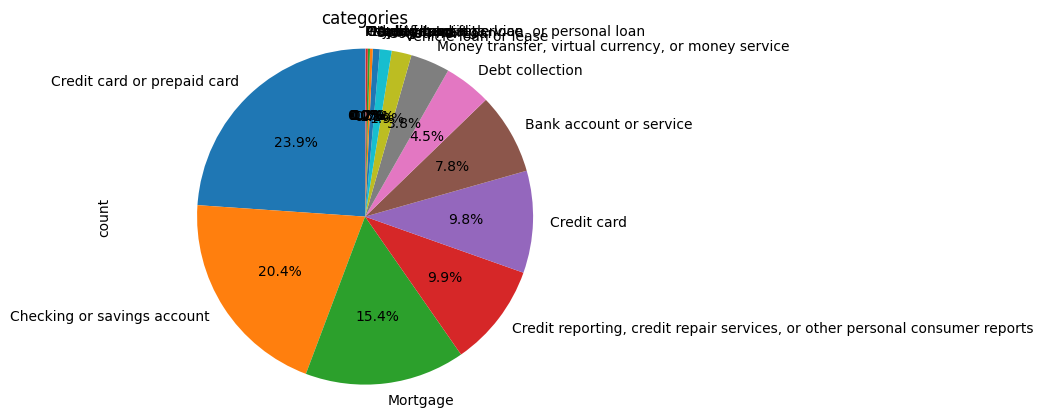

In [74]:
counts = df['product'].value_counts()
counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('categories')
plt.show()

In [75]:
# creating new column with merged 3 columns for category and drop previous columns
df['category'] = df['issue'] + ' / ' + df['product'] + ' / ' + df['sub_product']
df.drop(['issue', 'product', 'sub_product'], axis=1, inplace=True)

# text cleaning

In [76]:
data = df # replace to have possibility to load back original data
data['text_clean'] = data['complaint'].apply(lambda x: preprocess_text(x))
data['text_clean'] = data['text_clean'].apply(lambda x: lemmatize(x))
data['text_clean'] = data['text_clean'].apply(lambda x: remove_pos_tags(x))

data['text_clean'] = data['text_clean'].str.lower()
data['text_clean'] = data['text_clean'].str.replace('xxxx','')


### Check data

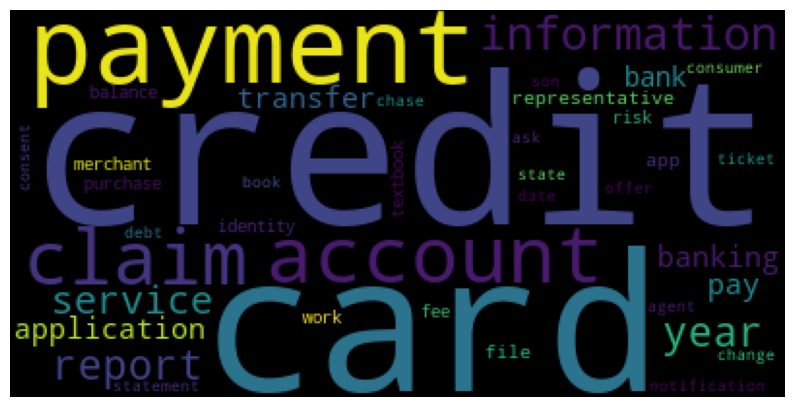

In [77]:

from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=STOP_WORDS, max_words=40).generate(str(data['text_clean']))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Topic Modelling
### in this dataset I have too much categories, so my plan is to change quantity of categories to 5.
### This can be done by NFM, LDA or LSA
###
###
###

### Vectorizer

In [78]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
dtm = tfidf.fit_transform(data['text_clean']) # document term metrix
feature_names = np.array(tfidf.get_feature_names_out())

In [79]:
# cv = CountVectorizer(min_df=2, max_df=0.95, stop_words='english')
# dtm = cv.fit_transform(data['text_clean']) # document term metrix
# feature_names = np.array(cv.get_feature_names_out())

### NFM

In [80]:


num_topics = 5 
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_matrix = nmf_model.fit_transform(dtm)

nmf_matrix_normalized = normalize(nmf_matrix, axis=1)

# Assign topics to documents
data['topic'] = nmf_matrix_normalized.argmax(axis=1)

# print top words for each group
for topic in range(num_topics):
    topic_words_idx = nmf_model.components_[topic].argsort()[-15:][::-1]
    topic_words = [feature_names[i] for i in topic_words_idx]
    
    print(f"Top 15 words for Topic {topic}:\n")
    print(topic_words)
    print("\n")

Top 15 words for Topic 0:

['account', 'check', 'money', 'bank', 'deposit', 'fund', 'day', 'branch', 'transfer', 'number', 'business', 'transaction', 'chase', 'customer', 'claim']


Top 15 words for Topic 1:

['credit', 'card', 'report', 'inquiry', 'account', 'score', 'company', 'information', 'chase', 'limit', 'application', 'debt', 'letter', 'year', 'balance']


Top 15 words for Topic 2:

['payment', 'balance', 'month', 'pay', 'statement', 'fee', 'time', 'day', 'mortgage', 'date', 'credit', 'year', 'auto', 'account', 'error']


Top 15 words for Topic 3:

['charge', 'card', 'dispute', 'fee', 'transaction', 'purchase', 'merchant', 'claim', 'service', 'refund', 'fraud', 'time', 'email', 'statement', 'balance']


Top 15 words for Topic 4:

['loan', 'mortgage', 'modification', 'home', 'property', 'year', 'letter', 'document', 'rate', 'request', 'time', 'foreclosure', 'refinance', 'information', 'sale']




In [81]:
data.topic.value_counts()

topic
0    5139
3    4924
1    4817
4    3818
2    2374
Name: count, dtype: int64

### MAPPING AND SAVING DF

In [82]:
topic_mapping = {
    0: 'Banking and Account activities',
    1: 'Credit/debits Cards',
    2: 'Other',
    3: 'Reporting/information',
    4: 'Loans/Mortgages'
}

#Replace Topics with Topic Names
data['topic'] = data['topic'].map(topic_mapping)

In [83]:
data.to_csv('data/data.csv', index=False) # saving dataset

### VISUALISE DATA FOR EACH NEWLY CREATED TOPIC

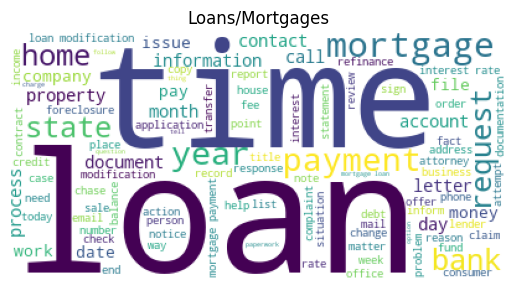

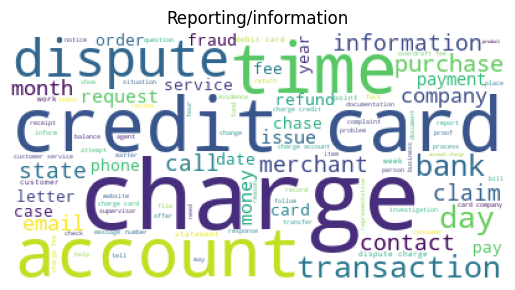

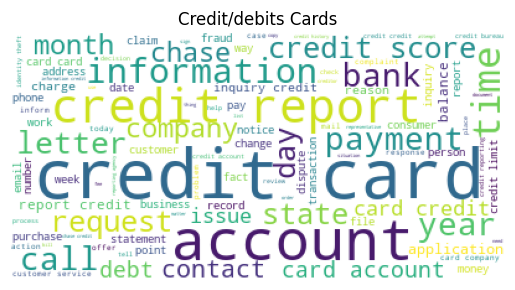

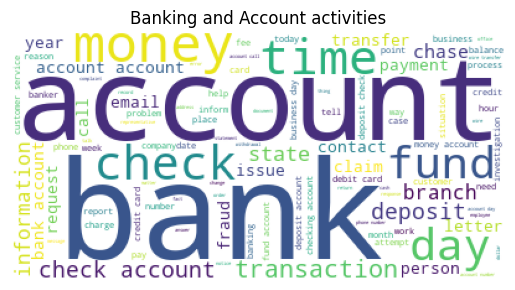

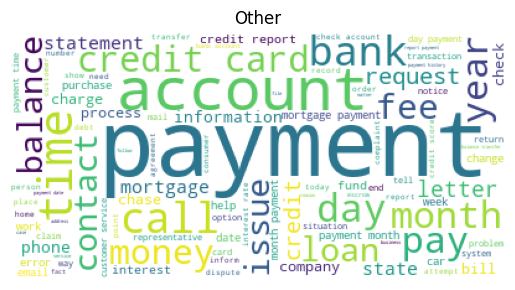

In [84]:
for x in data['topic'].unique():
	wc = WordCloud(background_color="white", max_words=100)
	wc.generate(data['text_clean'][(data['text_clean'].notnull()) & (data['topic'] == x)].to_string())
	plt.imshow(wc)
	plt.title(x)
	plt.axis("off")
	plt.show()

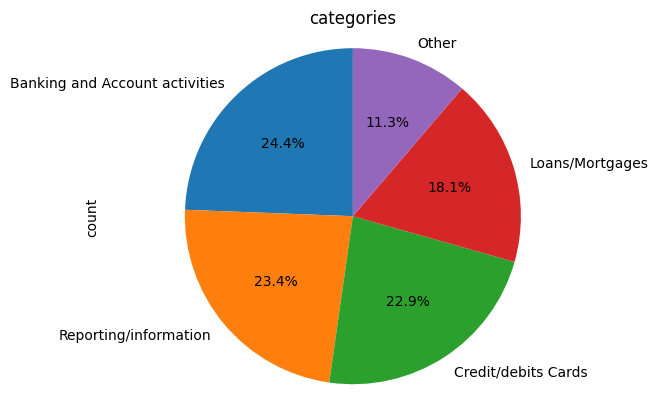

In [85]:
counts = data['topic'].value_counts()
counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('categories')
plt.show()

# Data Augmentation

In [86]:

topic_counts = data['topic'].value_counts()
max_count = topic_counts.max() # max items for main topic


# Loop for augmenting data
augmented_data = []
for topic, count in topic_counts.items():
    if count < max_count:
        topic_data = data[data['topic'] == topic]
        samples_needed = max_count - count
        
        # perform augmenation
        augmented_sentences = []
        while len(augmented_sentences) < samples_needed:
            augmented_sentence = augment_text(topic_data['text_clean'].sample().iloc[0])
            augmented_sentences.append(augmented_sentence)
        
        # create new dataframe with merged newly created samples and topics
        augmented_df = pd.DataFrame({'topic': [topic] * len(augmented_sentences), 'text_clean': augmented_sentences})

        # add samples from list to dataframe
        augmented_data.append(augmented_df)

# Merge augmented data with original data
augmented_data = pd.concat([data] + augmented_data, ignore_index=True)

# Print the results
print("Original data counts:")
print(data.topic.value_counts())
print("\nAugmented data counts:")
print(augmented_data.topic.value_counts())

# Save augmented dataset
augmented_data.to_csv('data/augmented_data.csv', index=False)

Original data counts:
topic
Banking and Account activities    5139
Reporting/information             4924
Credit/debits Cards               4817
Loans/Mortgages                   3818
Other                             2374
Name: count, dtype: int64

Augmented data counts:
topic
Loans/Mortgages                   5139
Reporting/information             5139
Credit/debits Cards               5139
Banking and Account activities    5139
Other                             5139
Name: count, dtype: int64


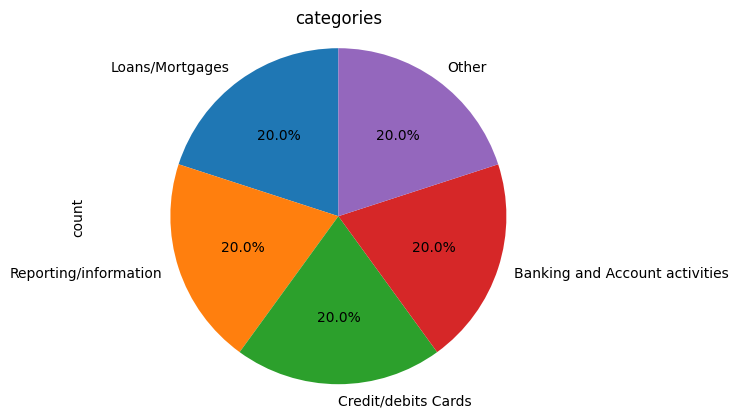

In [87]:
counts = augmented_data['topic'].value_counts()
counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('categories')
plt.show()

In [88]:
augmented_data.to_csv('data/augmented_data.csv', index=False) # saving dataset

# Machine Learning

In [89]:
df_scores = df = pd.DataFrame(columns=['Model', 'Training Score', 'Test Score']) 

In [90]:
# import dataset
data = pd.read_csv('data/augmented_data.csv')
data['text_clean'] = data['text_clean'].fillna('')
data[data['text_clean']==''] = np.nan
data = data[~data['text_clean'].isnull()]


In [91]:
training_data = data[['text_clean','topic']]
training_data['text_clean'] = training_data['text_clean'].fillna('')
training_data[training_data['text_clean']==''] = np.nan
training_data = training_data[~training_data['text_clean'].isnull()]

In [92]:
training_data = data[['text_clean','topic']]
X = training_data['text_clean']
y = training_data['topic']

In [93]:
from sklearn.feature_extraction.text import TfidfTransformer
cv = CountVectorizer()
X_vec = cv.fit_transform(X)
tfidf_t = TfidfTransformer()
X_tfidf = tfidf_t.fit_transform(X_vec)
joblib.dump(cv, 'pre-trained_models/cv.joblib')
joblib.dump(tfidf_t, 'pre-trained_models/tfidf.joblib')

['pre-trained_models/tfidf.joblib']

In [94]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=40, stratify=y)

### Logistic Regression Classificator


Training Accuracy: 0.9756548836303438

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.98      0.99      0.98      4094
           Credit/debits Cards       0.98      0.97      0.97      4111
               Loans/Mortgages       0.97      0.98      0.97      4111
                         Other       0.98      0.98      0.98      4111
         Reporting/information       0.98      0.97      0.97      4111

                      accuracy                           0.98     20538
                     macro avg       0.98      0.98      0.98     20538
                  weighted avg       0.98      0.98      0.98     20538

Testing Accuracy: 0.9534566699123661

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.95      0.96      0.96      1023
           Credit/debits Cards       0.95      0.94      0.94  

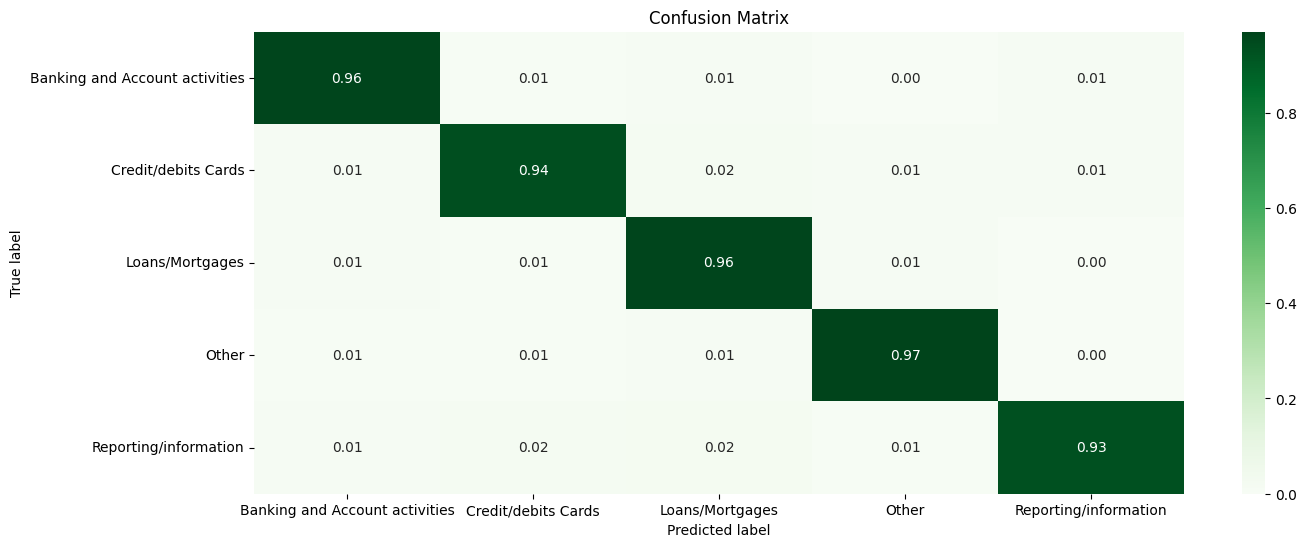

In [95]:
log_reg = LogisticRegression(random_state=40,solver='liblinear')
log_reg.fit(X_train,y_train)
joblib.dump(log_reg, 'pre-trained_models/logistic_regression.joblib')
display_classification_results(log_reg, X_train, y_train, X_test, y_test, 'Logistic Regression')

### Decision Tree Classificator


Training Accuracy: 1.0

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       1.00      1.00      1.00      4094
           Credit/debits Cards       1.00      1.00      1.00      4111
               Loans/Mortgages       1.00      1.00      1.00      4111
                         Other       1.00      1.00      1.00      4111
         Reporting/information       1.00      1.00      1.00      4111

                      accuracy                           1.00     20538
                     macro avg       1.00      1.00      1.00     20538
                  weighted avg       1.00      1.00      1.00     20538

Testing Accuracy: 0.817332035053554

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.82      0.83      0.82      1023
           Credit/debits Cards       0.82      0.82      0.82      1028
       

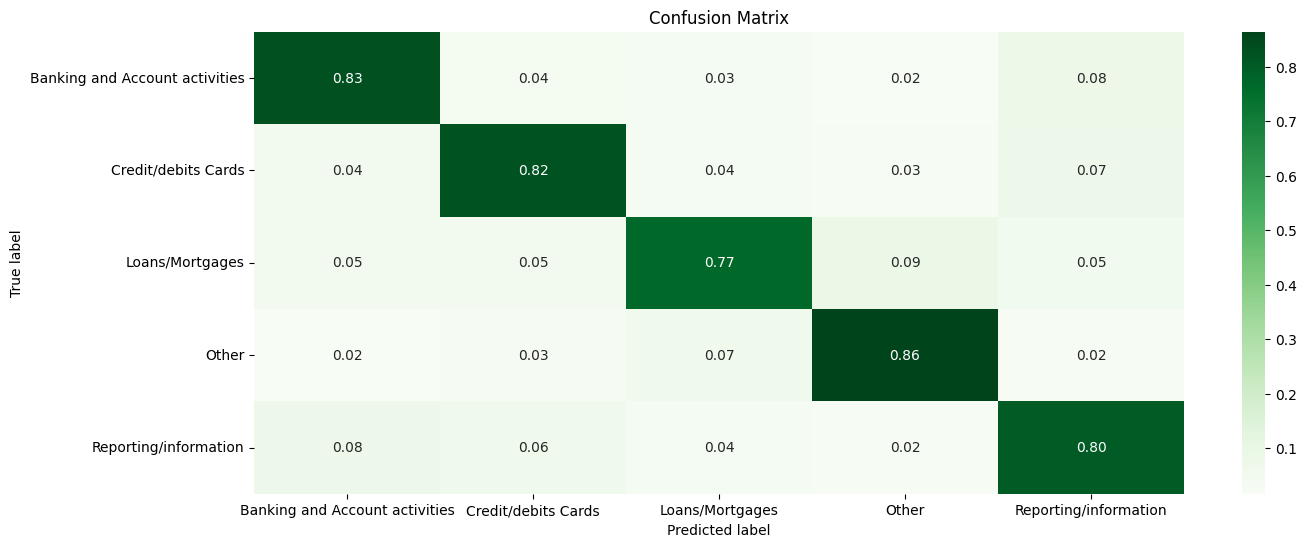

In [96]:
decision_tree = DecisionTreeClassifier(random_state=40)
decision_tree.fit(X_train,y_train)
display_classification_results(decision_tree, X_train, y_train, X_test, y_test, 'decision_tree')

### Random Forest Classificator


Training Accuracy: 1.0

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       1.00      1.00      1.00      4094
           Credit/debits Cards       1.00      1.00      1.00      4111
               Loans/Mortgages       1.00      1.00      1.00      4111
                         Other       1.00      1.00      1.00      4111
         Reporting/information       1.00      1.00      1.00      4111

                      accuracy                           1.00     20538
                     macro avg       1.00      1.00      1.00     20538
                  weighted avg       1.00      1.00      1.00     20538

Testing Accuracy: 0.8673807205452775

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.83      0.93      0.88      1023
           Credit/debits Cards       0.87      0.86      0.86      1028
      

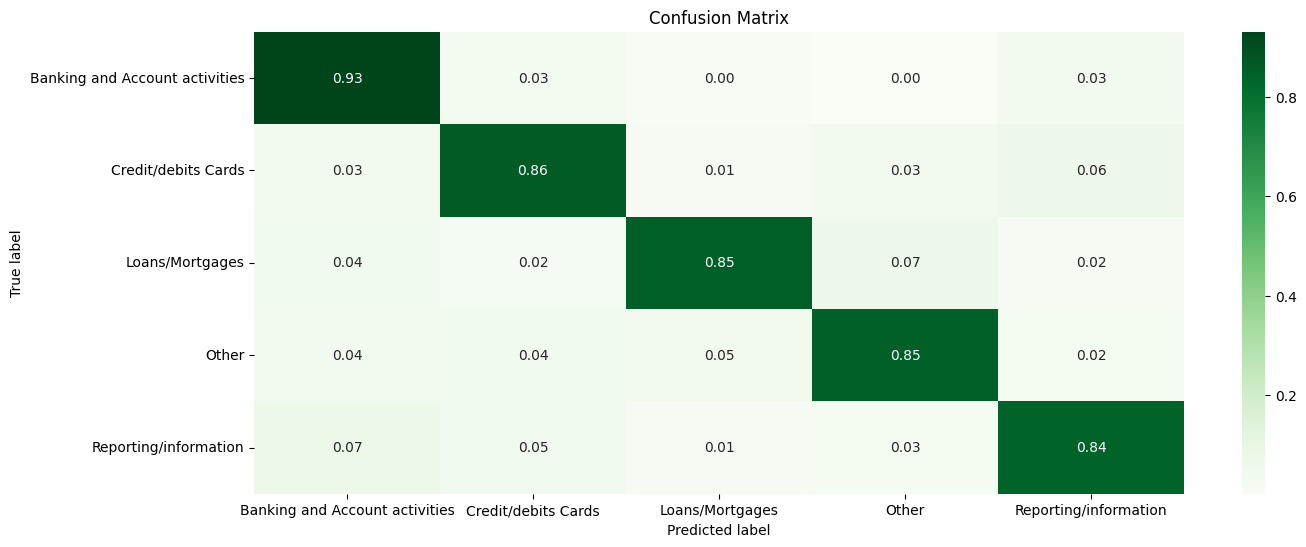

In [97]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=40)
random_forest.fit(X_train,y_train)
display_classification_results(random_forest, X_train, y_train, X_test, y_test, 'Random Forest')

### Support Vector Machine (SVM) Classificator


Training Accuracy: 0.9910409971759665

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.99      0.99      0.99      4094
           Credit/debits Cards       0.99      0.99      0.99      4111
               Loans/Mortgages       0.99      0.99      0.99      4111
                         Other       1.00      0.99      1.00      4111
         Reporting/information       0.99      0.99      0.99      4111

                      accuracy                           0.99     20538
                     macro avg       0.99      0.99      0.99     20538
                  weighted avg       0.99      0.99      0.99     20538

Testing Accuracy: 0.9520934761441091

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.96      0.95      0.96      1023
           Credit/debits Cards       0.94      0.95      0.95  

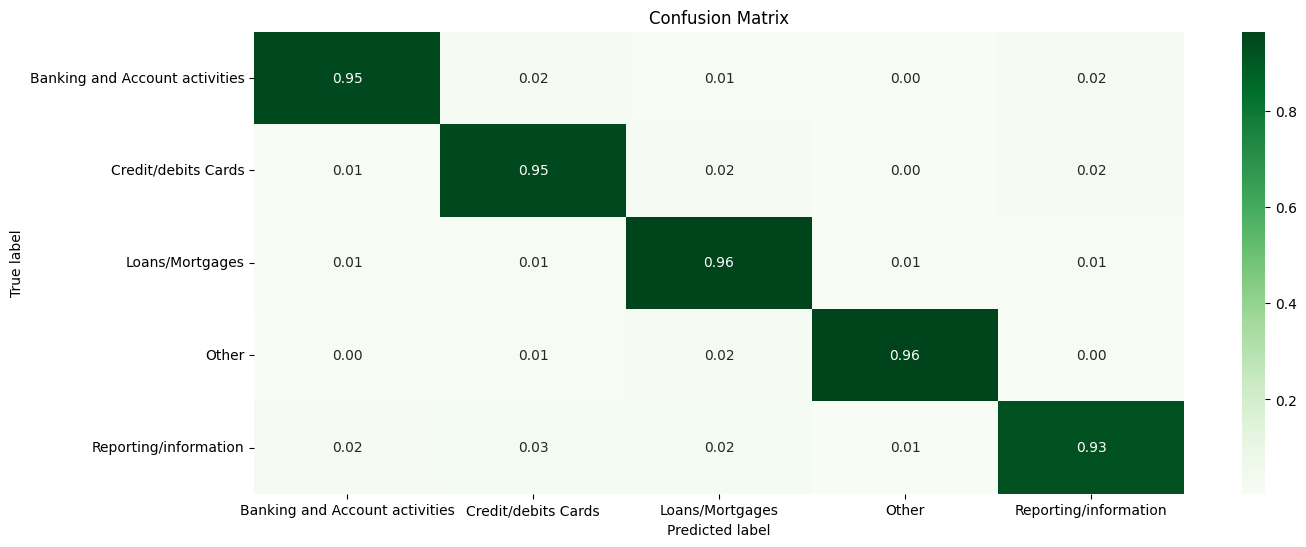

In [98]:
svm_classifier = SVC(kernel='linear',probability=True, random_state=40)
svm_classifier.fit(X_train,y_train)
display_classification_results(svm_classifier, X_train, y_train, X_test, y_test, 'Support Vector Machine')

### K-Nearest Neighbors Classificator


Training Accuracy: 0.40515142662381926

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.25      0.98      0.40      4094
           Credit/debits Cards       0.90      0.44      0.59      4111
               Loans/Mortgages       0.91      0.15      0.26      4111
                         Other       0.89      0.16      0.27      4111
         Reporting/information       0.91      0.30      0.45      4111

                      accuracy                           0.41     20538
                     macro avg       0.77      0.41      0.39     20538
                  weighted avg       0.77      0.41      0.39     20538

Testing Accuracy: 0.3744888023369036

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.24      0.97      0.39      1023
           Credit/debits Cards       0.89      0.40      0.55 

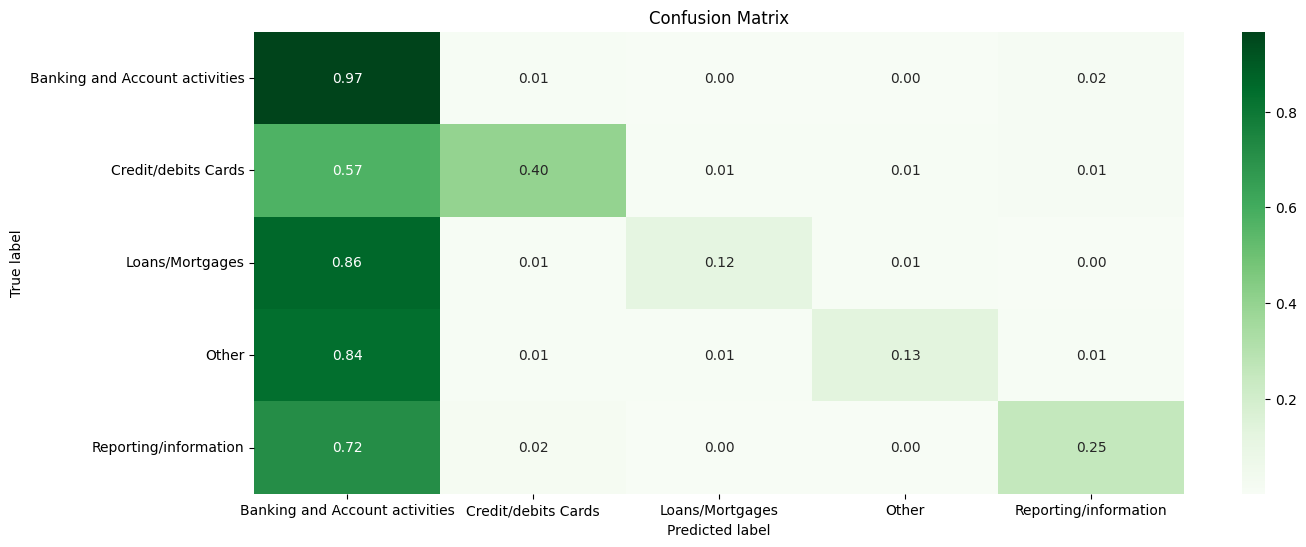

In [99]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train,y_train)
display_classification_results(knn_classifier, X_train, y_train, X_test, y_test, 'K-Nearest Neighbors')

### Naive Bayes Classificator


Training Accuracy: 0.6146168078683416

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.39      1.00      0.57      4094
           Credit/debits Cards       0.63      0.46      0.53      4111
               Loans/Mortgages       1.00      0.50      0.67      4111
                         Other       0.89      0.64      0.75      4111
         Reporting/information       0.89      0.47      0.62      4111

                      accuracy                           0.61     20538
                     macro avg       0.76      0.61      0.63     20538
                  weighted avg       0.76      0.61      0.63     20538

Testing Accuracy: 0.4

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.29      0.78      0.43      1023
           Credit/debits Cards       0.31      0.19      0.23      1028
      

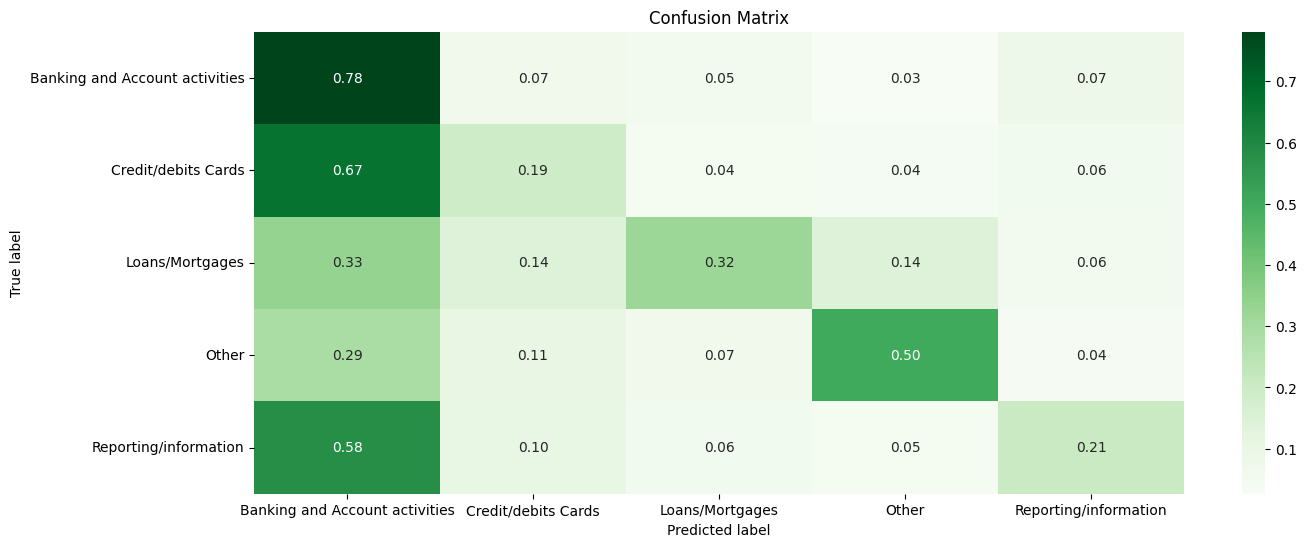

In [100]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train.toarray(),y_train)
display_classification_results(naive_bayes, X_train, y_train, X_test, y_test, 'Naive Bayes')

### AdaBoost Classificator


Training Accuracy: 0.8554386989969812

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.90      0.88      0.89      4094
           Credit/debits Cards       0.84      0.85      0.85      4111
               Loans/Mortgages       0.80      0.87      0.83      4111
                         Other       0.88      0.86      0.87      4111
         Reporting/information       0.86      0.81      0.84      4111

                      accuracy                           0.86     20538
                     macro avg       0.86      0.86      0.86     20538
                  weighted avg       0.86      0.86      0.86     20538

Testing Accuracy: 0.8494644595910419

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.91      0.86      0.88      1023
           Credit/debits Cards       0.85      0.86      0.85  

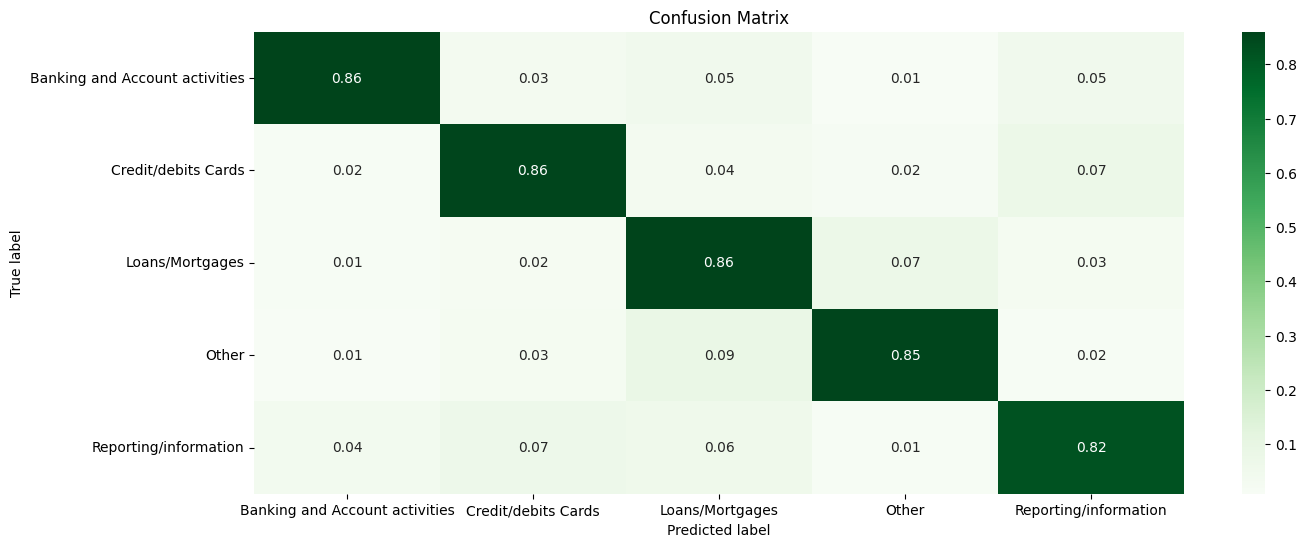

In [101]:
adaboost = AdaBoostClassifier(n_estimators=50, random_state=40)
adaboost.fit(X_train,y_train)
display_classification_results(adaboost, X_train, y_train, X_test, y_test, 'AdaBoost')

### Bagging Classificator


Training Accuracy: 0.9999513097672607

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       1.00      1.00      1.00      4094
           Credit/debits Cards       1.00      1.00      1.00      4111
               Loans/Mortgages       1.00      1.00      1.00      4111
                         Other       1.00      1.00      1.00      4111
         Reporting/information       1.00      1.00      1.00      4111

                      accuracy                           1.00     20538
                     macro avg       1.00      1.00      1.00     20538
                  weighted avg       1.00      1.00      1.00     20538

Testing Accuracy: 0.8763388510223953

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.85      0.90      0.87      1023
           Credit/debits Cards       0.87      0.89      0.88  

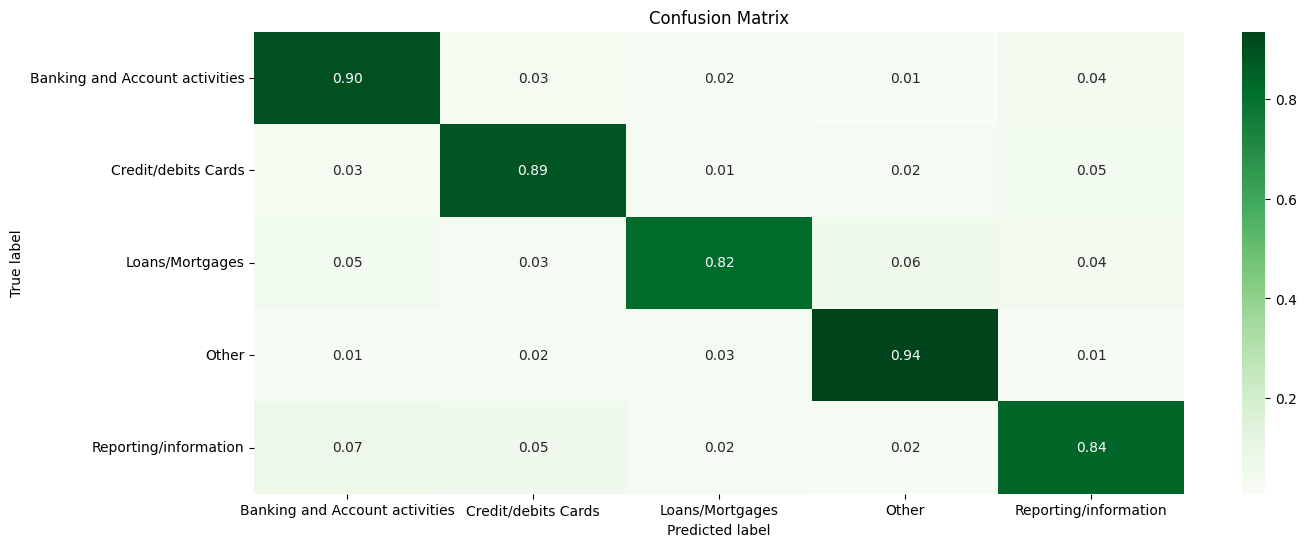

In [102]:
bagging = BaggingClassifier(n_estimators=50, random_state=40)
bagging.fit(X_train,y_train)
display_classification_results(bagging, X_train, y_train, X_test, y_test, 'Bagging Classifier')

### Extra Trees Classificator


Training Accuracy: 1.0

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       1.00      1.00      1.00      4094
           Credit/debits Cards       1.00      1.00      1.00      4111
               Loans/Mortgages       1.00      1.00      1.00      4111
                         Other       1.00      1.00      1.00      4111
         Reporting/information       1.00      1.00      1.00      4111

                      accuracy                           1.00     20538
                     macro avg       1.00      1.00      1.00     20538
                  weighted avg       1.00      1.00      1.00     20538

Testing Accuracy: 0.8625121713729309

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.84      0.94      0.89      1023
           Credit/debits Cards       0.88      0.84      0.86      1028
      

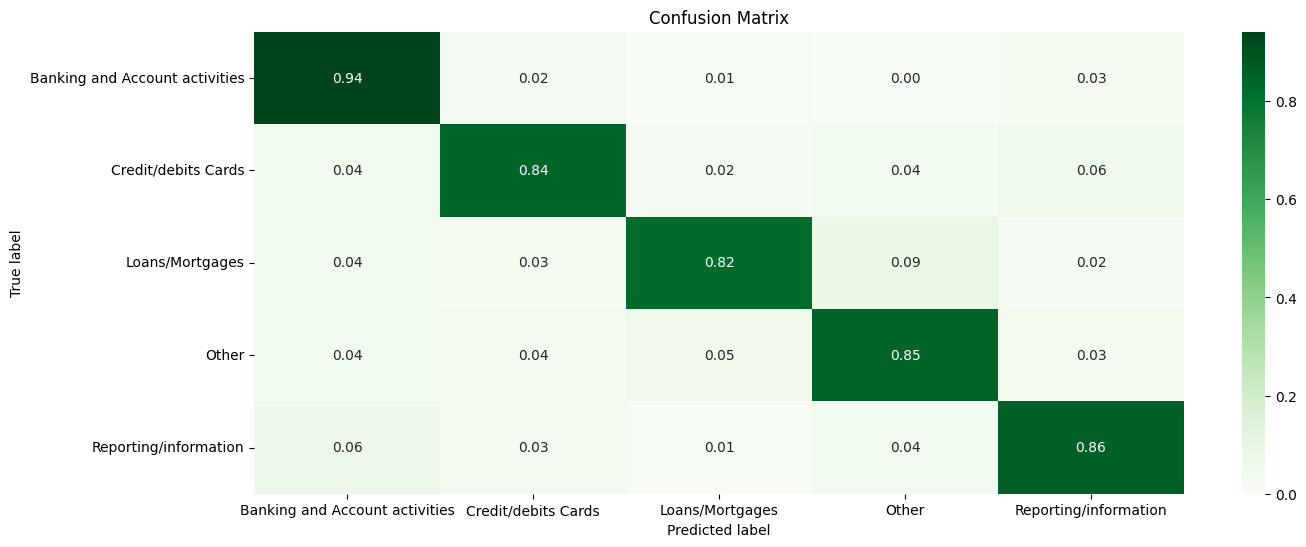

In [103]:
extra_trees = ExtraTreesClassifier(n_estimators=100, random_state=40)
extra_trees.fit(X_train,y_train)
display_classification_results(extra_trees, X_train, y_train, X_test, y_test, 'Extra Trees Classifier')

### Multi-layer Perceptron (Neural Networks) Classificator


Training Accuracy: 0.9999513097672607

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       1.00      1.00      1.00      4094
           Credit/debits Cards       1.00      1.00      1.00      4111
               Loans/Mortgages       1.00      1.00      1.00      4111
                         Other       1.00      1.00      1.00      4111
         Reporting/information       1.00      1.00      1.00      4111

                      accuracy                           1.00     20538
                     macro avg       1.00      1.00      1.00     20538
                  weighted avg       1.00      1.00      1.00     20538

Testing Accuracy: 0.9164556962025316

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.89      0.94      0.91      1023
           Credit/debits Cards       0.94      0.86      0.90  

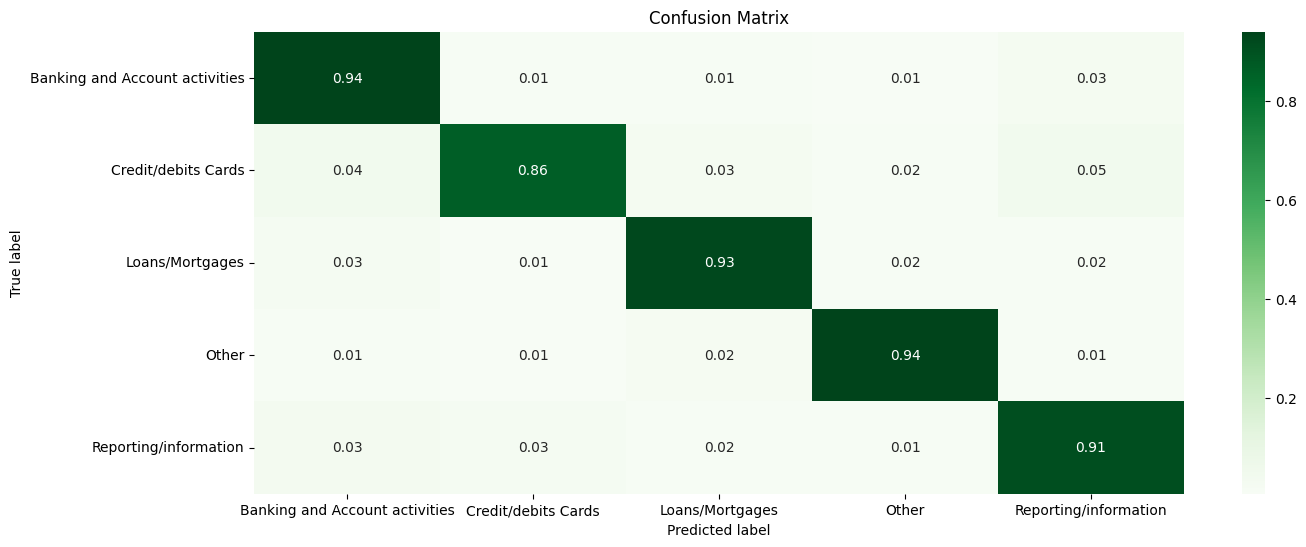

In [104]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=40)
mlp.fit(X_train,y_train)
display_classification_results(mlp, X_train, y_train, X_test, y_test, 'Multi-layer Perceptron')

### Gradient Boosting Classificator


Training Accuracy: 0.9501898919076833

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.96      0.97      0.96      4094
           Credit/debits Cards       0.96      0.94      0.95      4111
               Loans/Mortgages       0.92      0.95      0.93      4111
                         Other       0.96      0.97      0.97      4111
         Reporting/information       0.95      0.92      0.94      4111

                      accuracy                           0.95     20538
                     macro avg       0.95      0.95      0.95     20538
                  weighted avg       0.95      0.95      0.95     20538

Testing Accuracy: 0.917429406037001

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.93      0.93      0.93      1023
           Credit/debits Cards       0.92      0.91      0.92   

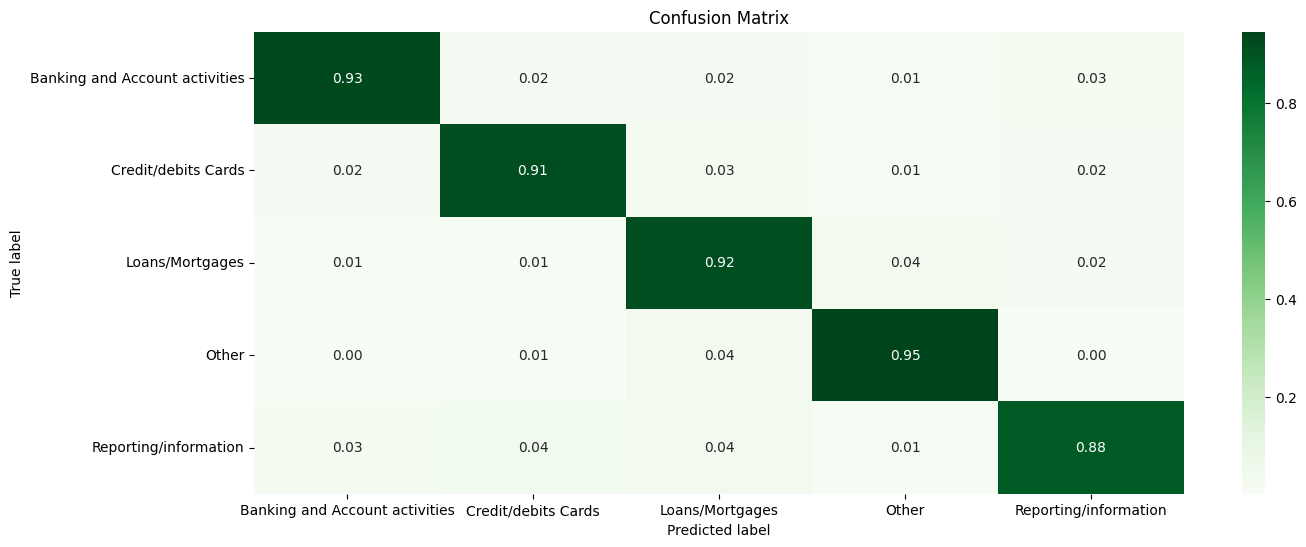

In [105]:
gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=40)
gradient_boosting.fit(X_train,y_train)
display_classification_results(gradient_boosting, X_train, y_train, X_test, y_test, 'Gradient Boosting Classifier')

### Quadratic Discriminant Analysis Classificator


Training Accuracy: 0.8882072256305386

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.93      0.85      0.89      4094
           Credit/debits Cards       0.67      1.00      0.80      4111
               Loans/Mortgages       1.00      0.90      0.95      4111
                         Other       1.00      0.87      0.93      4111
         Reporting/information       1.00      0.82      0.90      4111

                      accuracy                           0.89     20538
                     macro avg       0.92      0.89      0.89     20538
                  weighted avg       0.92      0.89      0.89     20538

Testing Accuracy: 0.347809152872444

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.35      0.30      0.33      1023
           Credit/debits Cards       0.37      0.48      0.42   

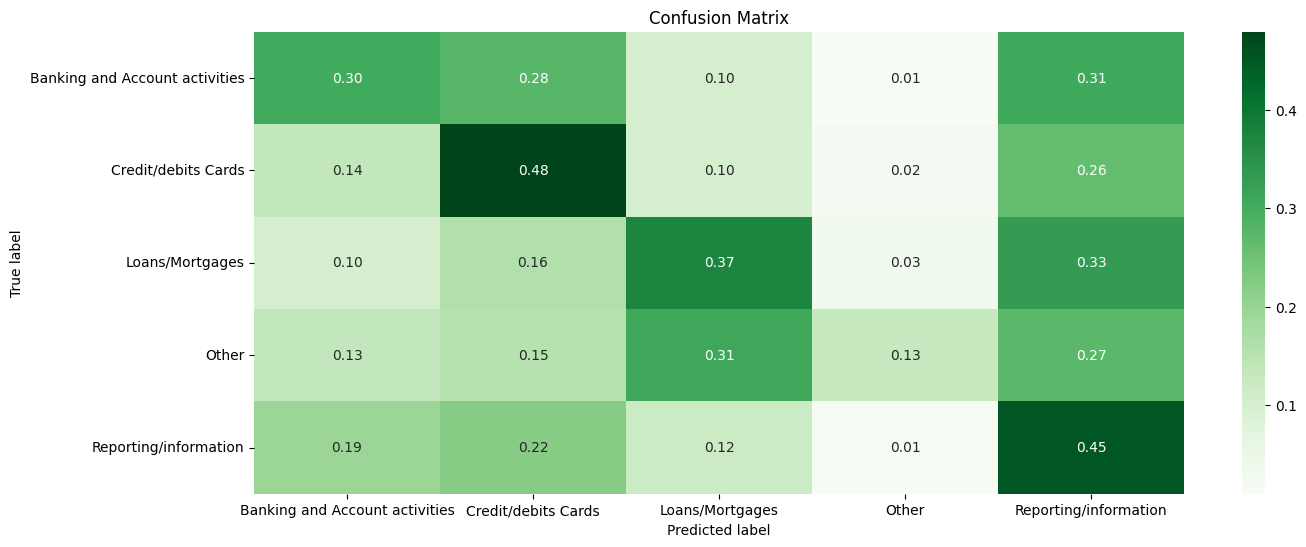

In [106]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train.toarray(),y_train)
display_classification_results(qda, X_train, y_train, X_test, y_test, 'Quadratic Discriminant Analysis')

In [107]:
df_scores.sort_values(by='Test Score', ascending=False, inplace=True) # sorting test scores
df_scores.to_csv('data/df_scores.csv', index=False) # saving dataset

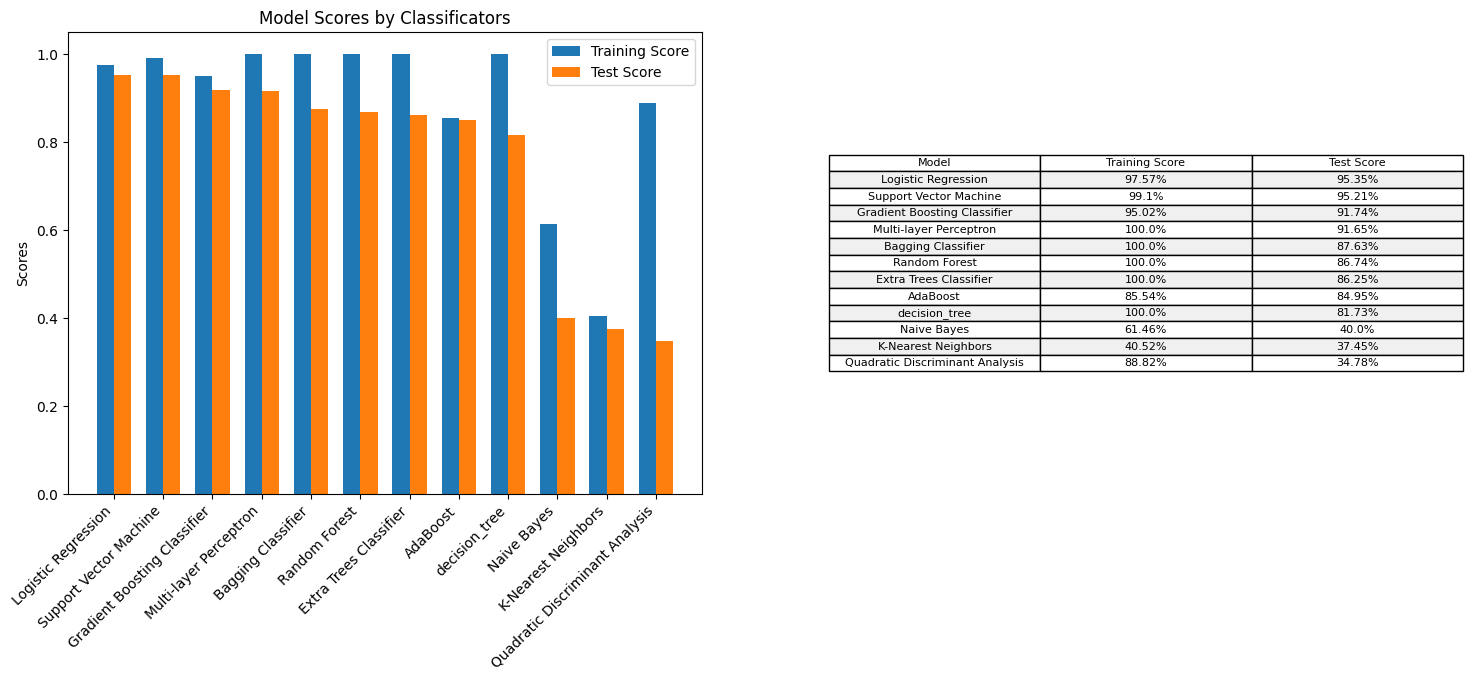

In [108]:
# Import dataset
df_scores = pd.read_csv('data/df_scores.csv')

# Merge 2 visualisations
width = 0.35
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1]})

# Bar plot
x = range(len(df_scores))
rects1 = ax1.bar(x, df_scores['Training Score'], width, label='Training Score')
rects2 = ax1.bar([i + width for i in x], df_scores['Test Score'], width, label='Test Score')

# Labels for bar plot
ax1.set_ylabel('Scores')
ax1.set_title('Model Scores by Classificators')
ax1.set_xticks([i + width/2 for i in x])
ax1.set_xticklabels(df_scores['Model'], rotation=45, ha='right')
ax1.legend()

# Dataframe display
num_columns = df_scores.columns.difference(['Model'])
df_scores[num_columns] = df_scores[num_columns] * 100
df_scores[num_columns] = df_scores[num_columns].round(2).astype(str) + '%'

ax2.axis('off')
table_data = ax2.table(cellText=df_scores.values, colLabels=df_scores.columns, cellLoc='center', loc='center')
table_data.auto_set_font_size(False)
table_data.set_fontsize(8)

for i in range(len(df_scores)):
    for j in range(len(df_scores.columns)):
        cell_value = df_scores.iloc[i, j]
        color = '#f0f0f0' if i % 2 == 0 else '#ffffff'
        table_data[(i + 1, j)].set_facecolor(color)

plt.show()